# 3 layer LSTM Encoder Decoder, dropout. 120 day input, 10 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Conv1D, CuDNNGRU, Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm4.671'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
num_skew_end = 15
data = df.values[:-num_skew_end]

In [3]:
num_input = 120
num_out = 10
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (585, 120, 25)
train_y shape (585, 10, 1)
dev_X shape (69, 120, 25)
dev_y shape (69, 10, 1)
test_X shape (35, 120, 25)
test_y shape (35, 10, 1)
train_y_acc shape (585, 10, 1)
dev_y_acc shape (69, 10, 1)
test_y_acc shape (35, 10, 1)


In [4]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.3
epochs = 1000
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=input_shape))
model.add(CuDNNGRU(200))
model.add(Dropout(dropout_rate))
model.add(RepeatVector(num_out))
model.add(CuDNNGRU(200, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mae", optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 111, 64)           16064     
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 200)               159600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 200)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 10, 200)           241200    
_________________________________________________________________
dropout_2 (Dropout)  

In [5]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 1000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 585 samples, validate on 69 samples
Epoch 1/1000
585/585 [==============================] - 5s 8ms/step - loss: 0.1193 - val_loss: 0.0637
Epoch 2/1000
585/585 [==============================] - 1s 941us/step - loss: 0.0656 - val_loss: 0.0463
Epoch 3/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0537 - val_loss: 0.0495
Epoch 4/1000
585/585 [==============================] - 1s 921us/step - loss: 0.0483 - val_loss: 0.0664
Epoch 5/1000
585/585 [==============================] - 1s 916us/step - loss: 0.0434 - val_loss: 0.0555
Epoch 6/1000
585/585 [==============================] - 1s 903us/step - loss: 0.0421 - val_loss: 0.0365
Epoch 7/1000
585/585 [==============================] - 1s 898us/step - loss: 0.0394 - val_loss: 0.0592
Epoch 8/1000
585/585 [==============================] - 1s 904us/step - loss: 0.0379 - val_loss: 0.0372
Epoch 9/1000
585/

585/585 [==============================] - 1s 912us/step - loss: 0.0189 - val_loss: 0.0215
Epoch 76/1000
585/585 [==============================] - 1s 898us/step - loss: 0.0177 - val_loss: 0.0205
Epoch 77/1000
585/585 [==============================] - 1s 902us/step - loss: 0.0179 - val_loss: 0.0175
Epoch 78/1000
585/585 [==============================] - 1s 899us/step - loss: 0.0171 - val_loss: 0.0195
Epoch 79/1000
585/585 [==============================] - 1s 896us/step - loss: 0.0189 - val_loss: 0.0197
Epoch 80/1000
585/585 [==============================] - 1s 901us/step - loss: 0.0188 - val_loss: 0.0223
Epoch 81/1000
585/585 [==============================] - 1s 918us/step - loss: 0.0188 - val_loss: 0.0198
Epoch 82/1000
585/585 [==============================] - 1s 901us/step - loss: 0.0181 - val_loss: 0.0222
Epoch 83/1000
585/585 [==============================] - 1s 908us/step - loss: 0.0177 - val_loss: 0.0213
Epoch 84/1000
585/585 [==============================] - 1s 915us/ste

585/585 [==============================] - 1s 905us/step - loss: 0.0147 - val_loss: 0.0137
Epoch 153/1000
585/585 [==============================] - 1s 908us/step - loss: 0.0151 - val_loss: 0.0169
Epoch 154/1000
585/585 [==============================] - 1s 902us/step - loss: 0.0146 - val_loss: 0.0143
Epoch 155/1000
585/585 [==============================] - 1s 902us/step - loss: 0.0154 - val_loss: 0.0207
Epoch 156/1000
585/585 [==============================] - 1s 906us/step - loss: 0.0162 - val_loss: 0.0146
Epoch 157/1000
585/585 [==============================] - 1s 906us/step - loss: 0.0153 - val_loss: 0.0153
Epoch 158/1000
585/585 [==============================] - 1s 912us/step - loss: 0.0149 - val_loss: 0.0138
Epoch 159/1000
585/585 [==============================] - 1s 921us/step - loss: 0.0149 - val_loss: 0.0149
Epoch 160/1000
585/585 [==============================] - 1s 908us/step - loss: 0.0148 - val_loss: 0.0151
Epoch 161/1000
585/585 [==============================] - 1s 

585/585 [==============================] - 1s 903us/step - loss: 0.0138 - val_loss: 0.0142
Epoch 230/1000
585/585 [==============================] - 1s 903us/step - loss: 0.0139 - val_loss: 0.0128
Epoch 231/1000
585/585 [==============================] - 1s 913us/step - loss: 0.0129 - val_loss: 0.0136
Epoch 232/1000
585/585 [==============================] - 1s 905us/step - loss: 0.0127 - val_loss: 0.0134
Epoch 233/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0126 - val_loss: 0.0126
Epoch 234/1000
585/585 [==============================] - 1s 898us/step - loss: 0.0131 - val_loss: 0.0123
Epoch 235/1000
585/585 [==============================] - 1s 907us/step - loss: 0.0136 - val_loss: 0.0162
Epoch 236/1000
585/585 [==============================] - 1s 903us/step - loss: 0.0127 - val_loss: 0.0159
Epoch 237/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0124 - val_loss: 0.0134
Epoch 238/1000
585/585 [==============================] - 1s 

585/585 [==============================] - 1s 908us/step - loss: 0.0116 - val_loss: 0.0127
Epoch 307/1000
585/585 [==============================] - 1s 906us/step - loss: 0.0118 - val_loss: 0.0131
Epoch 308/1000
585/585 [==============================] - 1s 910us/step - loss: 0.0120 - val_loss: 0.0152
Epoch 309/1000
585/585 [==============================] - 1s 903us/step - loss: 0.0122 - val_loss: 0.0127
Epoch 310/1000
585/585 [==============================] - 1s 912us/step - loss: 0.0126 - val_loss: 0.0139
Epoch 311/1000
585/585 [==============================] - 1s 898us/step - loss: 0.0141 - val_loss: 0.0153
Epoch 312/1000
585/585 [==============================] - 1s 898us/step - loss: 0.0151 - val_loss: 0.0226
Epoch 313/1000
585/585 [==============================] - 1s 901us/step - loss: 0.0138 - val_loss: 0.0151
Epoch 314/1000
585/585 [==============================] - 1s 918us/step - loss: 0.0140 - val_loss: 0.0156
Epoch 315/1000
585/585 [==============================] - 1s 

585/585 [==============================] - 1s 910us/step - loss: 0.0116 - val_loss: 0.0148
Epoch 384/1000
585/585 [==============================] - 1s 901us/step - loss: 0.0114 - val_loss: 0.0113
Epoch 385/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0118 - val_loss: 0.0120
Epoch 386/1000
585/585 [==============================] - 1s 902us/step - loss: 0.0115 - val_loss: 0.0133
Epoch 387/1000
585/585 [==============================] - 1s 905us/step - loss: 0.0117 - val_loss: 0.0157
Epoch 388/1000
585/585 [==============================] - 1s 904us/step - loss: 0.0120 - val_loss: 0.0112
Epoch 389/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0126 - val_loss: 0.0137
Epoch 390/1000
585/585 [==============================] - 1s 902us/step - loss: 0.0113 - val_loss: 0.0127
Epoch 391/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0114 - val_loss: 0.0125
Epoch 392/1000
585/585 [==============================] - 1s 

585/585 [==============================] - 1s 902us/step - loss: 0.0111 - val_loss: 0.0110
Epoch 461/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0114 - val_loss: 0.0133
Epoch 462/1000
585/585 [==============================] - 1s 907us/step - loss: 0.0111 - val_loss: 0.0119
Epoch 463/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0113 - val_loss: 0.0115
Epoch 464/1000
585/585 [==============================] - 1s 896us/step - loss: 0.0106 - val_loss: 0.0113
Epoch 465/1000
585/585 [==============================] - 1s 902us/step - loss: 0.0107 - val_loss: 0.0118
Epoch 466/1000
585/585 [==============================] - 1s 902us/step - loss: 0.0106 - val_loss: 0.0116
Epoch 467/1000
585/585 [==============================] - 1s 897us/step - loss: 0.0111 - val_loss: 0.0116
Epoch 468/1000
585/585 [==============================] - 1s 903us/step - loss: 0.0113 - val_loss: 0.0114
Epoch 469/1000
585/585 [==============================] - 1s 

585/585 [==============================] - 1s 903us/step - loss: 0.0105 - val_loss: 0.0138
Epoch 538/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0104 - val_loss: 0.0107
Epoch 539/1000
585/585 [==============================] - 1s 896us/step - loss: 0.0102 - val_loss: 0.0136
Epoch 540/1000
585/585 [==============================] - 1s 898us/step - loss: 0.0104 - val_loss: 0.0128
Epoch 541/1000
585/585 [==============================] - 1s 897us/step - loss: 0.0099 - val_loss: 0.0109
Epoch 542/1000
585/585 [==============================] - 1s 906us/step - loss: 0.0095 - val_loss: 0.0107
Epoch 543/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0100 - val_loss: 0.0109
Epoch 544/1000
585/585 [==============================] - 1s 908us/step - loss: 0.0101 - val_loss: 0.0120
Epoch 545/1000
585/585 [==============================] - 1s 906us/step - loss: 0.0108 - val_loss: 0.0110
Epoch 546/1000
585/585 [==============================] - 1s 

585/585 [==============================] - 1s 901us/step - loss: 0.0096 - val_loss: 0.0118
Epoch 615/1000
585/585 [==============================] - 1s 905us/step - loss: 0.0100 - val_loss: 0.0124
Epoch 616/1000
585/585 [==============================] - 1s 912us/step - loss: 0.0101 - val_loss: 0.0115
Epoch 617/1000
585/585 [==============================] - 1s 915us/step - loss: 0.0099 - val_loss: 0.0098
Epoch 618/1000
585/585 [==============================] - 1s 920us/step - loss: 0.0100 - val_loss: 0.0138
Epoch 619/1000
585/585 [==============================] - 1s 908us/step - loss: 0.0101 - val_loss: 0.0121
Epoch 620/1000
585/585 [==============================] - 1s 920us/step - loss: 0.0095 - val_loss: 0.0139
Epoch 621/1000
585/585 [==============================] - 1s 927us/step - loss: 0.0100 - val_loss: 0.0119
Epoch 622/1000
585/585 [==============================] - 1s 910us/step - loss: 0.0098 - val_loss: 0.0104
Epoch 623/1000
585/585 [==============================] - 1s 

585/585 [==============================] - 1s 902us/step - loss: 0.0099 - val_loss: 0.0095
Epoch 692/1000
585/585 [==============================] - 1s 899us/step - loss: 0.0096 - val_loss: 0.0113
Epoch 693/1000
585/585 [==============================] - 1s 903us/step - loss: 0.0100 - val_loss: 0.0139
Epoch 694/1000
585/585 [==============================] - 1s 897us/step - loss: 0.0105 - val_loss: 0.0101
Epoch 695/1000
585/585 [==============================] - 1s 905us/step - loss: 0.0107 - val_loss: 0.0141
Epoch 696/1000
585/585 [==============================] - 1s 914us/step - loss: 0.0102 - val_loss: 0.0117
Epoch 697/1000
585/585 [==============================] - 1s 904us/step - loss: 0.0094 - val_loss: 0.0099
Epoch 698/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0091 - val_loss: 0.0097
Epoch 699/1000
585/585 [==============================] - 1s 902us/step - loss: 0.0097 - val_loss: 0.0090
Epoch 700/1000
585/585 [==============================] - 1s 

585/585 [==============================] - 1s 897us/step - loss: 0.0096 - val_loss: 0.0096
Epoch 769/1000
585/585 [==============================] - 1s 899us/step - loss: 0.0094 - val_loss: 0.0087
Epoch 770/1000
585/585 [==============================] - 1s 904us/step - loss: 0.0089 - val_loss: 0.0121
Epoch 771/1000
585/585 [==============================] - 1s 904us/step - loss: 0.0092 - val_loss: 0.0111
Epoch 772/1000
585/585 [==============================] - 1s 912us/step - loss: 0.0100 - val_loss: 0.0096
Epoch 773/1000
585/585 [==============================] - 1s 903us/step - loss: 0.0091 - val_loss: 0.0110
Epoch 774/1000
585/585 [==============================] - 1s 901us/step - loss: 0.0092 - val_loss: 0.0097
Epoch 775/1000
585/585 [==============================] - 1s 904us/step - loss: 0.0095 - val_loss: 0.0095
Epoch 776/1000
585/585 [==============================] - 1s 912us/step - loss: 0.0095 - val_loss: 0.0114
Epoch 777/1000
585/585 [==============================] - 1s 

585/585 [==============================] - 1s 901us/step - loss: 0.0087 - val_loss: 0.0114
Epoch 846/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0087 - val_loss: 0.0094
Epoch 847/1000
585/585 [==============================] - 1s 905us/step - loss: 0.0088 - val_loss: 0.0099
Epoch 848/1000
585/585 [==============================] - 1s 898us/step - loss: 0.0087 - val_loss: 0.0100
Epoch 849/1000
585/585 [==============================] - 1s 902us/step - loss: 0.0085 - val_loss: 0.0112
Epoch 850/1000
585/585 [==============================] - 1s 901us/step - loss: 0.0086 - val_loss: 0.0096
Epoch 851/1000
585/585 [==============================] - 1s 899us/step - loss: 0.0085 - val_loss: 0.0095
Epoch 852/1000
585/585 [==============================] - 1s 909us/step - loss: 0.0085 - val_loss: 0.0112
Epoch 853/1000
585/585 [==============================] - 1s 907us/step - loss: 0.0092 - val_loss: 0.0114
Epoch 854/1000
585/585 [==============================] - 1s 

585/585 [==============================] - 1s 913us/step - loss: 0.0085 - val_loss: 0.0086
Epoch 923/1000
585/585 [==============================] - 1s 898us/step - loss: 0.0088 - val_loss: 0.0113
Epoch 924/1000
585/585 [==============================] - 1s 904us/step - loss: 0.0084 - val_loss: 0.0094
Epoch 925/1000
585/585 [==============================] - 1s 900us/step - loss: 0.0084 - val_loss: 0.0084
Epoch 926/1000
585/585 [==============================] - 1s 898us/step - loss: 0.0087 - val_loss: 0.0106
Epoch 927/1000
585/585 [==============================] - 1s 902us/step - loss: 0.0086 - val_loss: 0.0083
Epoch 928/1000
585/585 [==============================] - 1s 909us/step - loss: 0.0084 - val_loss: 0.0106
Epoch 929/1000
585/585 [==============================] - 1s 899us/step - loss: 0.0082 - val_loss: 0.0092
Epoch 930/1000
585/585 [==============================] - 1s 898us/step - loss: 0.0080 - val_loss: 0.0083
Epoch 931/1000
585/585 [==============================] - 1s 

585/585 [==============================] - 1s 903us/step - loss: 0.0083 - val_loss: 0.0082
Epoch 1000/1000
585/585 [==============================] - 1s 902us/step - loss: 0.0093 - val_loss: 0.0091
[Model] Training Completed. Model saved as models/lstm4.671/06062019-200829-e1000.h5


In [6]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

print("MAE Train:", mean_absolute_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MAE Dev:", mean_absolute_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MAE Test:", mean_absolute_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.0001181574501482481
MSE Dev: 0.00019405569960022898
MSE Test: 0.0002435247295984126
MAE Train: 0.007481285019926424
MAE Dev: 0.009115330419735682
MAE Test: 0.012313681098450484


In [7]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

l = go.Scatter(y=history.history['loss'], name='train')
v = go.Scatter(y=history.history['val_loss'], name='dev')

data = [v,l]
py.iplot(data, filename='line-mode')

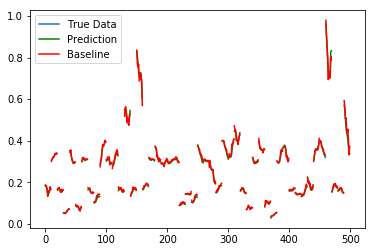

In [8]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_train.tolist()[:50], [], num_out, baseline_data=true_train.tolist()[:50])

# predicted_train = model.predict(train_X).squeeze()
# predicted_train = predicted_train[:, 0].reshape(-1,1)
# true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_train[:50], true_train[:50])

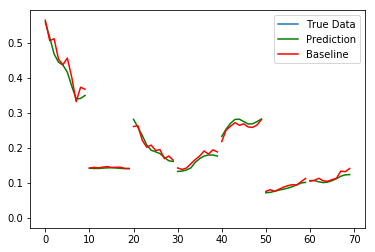

VAR MAE Dev: 0.005448766939753039
LSTM MAE Dev: 0.00014423459025663732
VAR MSE Dev: 0.005448766939753039
LSTM MSE Dev: 0.00014423459025663732


In [9]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_dev.tolist(), [0], num_out, baseline_data=true_dev.tolist())

true_dev = true_dev.reshape(-1,1)

var_preds_dev = utils.var_predict(dev_X[:, :, 0:5], num_out)
var_preds_dev = var_preds_dev[::num_out]

print("VAR MAE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MAE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

print("VAR MSE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

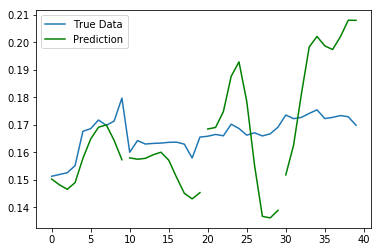

In [10]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[::num_out].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

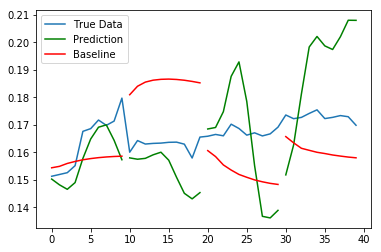

VAR MAE Test: 0.014679061944746335
LSTM MAE Test: 0.014257777001050983
VAR MSE Test: 0.0002570678369552715
LSTM MSE Test: 0.00031896329585303604


In [11]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
var_preds = var_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=var_preds.tolist())

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("VAR MSE Test:", mean_squared_error(var_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



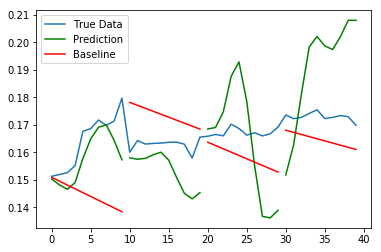

ARIMA MAE Test: 0.011817364924727753
LSTM MAE Test: 0.014257777001050983
ARIMA MSE Test: 0.00021404134489758325
LSTM MSE Test: 0.00031896329585303604


In [12]:
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
arima_preds = arima_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=arima_preds.tolist())

print("ARIMA MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("ARIMA MSE Test:", mean_squared_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

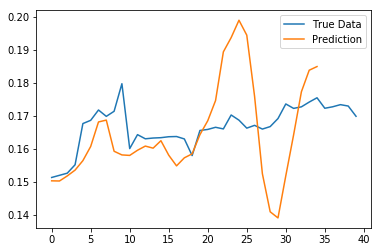

In [13]:
predicted_test_single = model.predict(test_X).squeeze()
predicted_test_single = predicted_test_single[:, 0]
utils.plot_results(predicted_test_single, true_test)